In [ ]:
# -*- coding: utf-8 -*-
"""RNN (LSTM) Coding Example

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1FOX_CmzcNxf7AD2ceQ9Bz-q8ySiG3Wta

# Coding Example 1: Temperature Time Series Forecasting with LSTM
"""

import tensorflow as tf
import os
import pandas as pd
import numpy as np

"""## Data Exploration

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany. The dataset contains 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.
"""

# Download the weather time series dataset from a URL using Keras API
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
# Separate the csv file path and the .zip extension
csv_path, extension = os.path.splitext(zip_path)

# read csv into pandas dataframe
df = pd.read_csv(csv_path)
df.head(15)

# sub-sampling the data from 10-minute intervals to one-hour intervals
hourly = df[5::6]
hourly.head(10)

# Reset index to timestamps
hourly.index = pd.to_datetime(hourly['Date Time'], format='%d.%m.%Y %H:%M:%S')
hourly.head(10)

# Extract Temperature in degree C
temp = hourly['T (degC)']
temp = pd.DataFrame(temp)
temp.head(10)

temp.info()

# Visualize the time series
temp.plot()

"""## Data Preparation

In this example we will use data of 5 consecutive time steps as input to predict the value of the next time step

Input (5 time steps) -> Output (the next time step)

`[[0], [1], [2], [3], [4]] -> [pred 5]`

`[[1], [2], [3], [4], [5]] -> [pred 6]`

`[[2], [3], [4], [5], [6]] -> [pred 7]`

`[[3], [4], [5], [6], [7]] -> [pred 8]`

`...`
"""

# standarize input data
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
temp_std = scaler.fit_transform(temp)
temp_std

# Define a funtion that transforms the time series into proper format for input

def to_X_y(data, window_size):
  '''
    Transforms the time series into numpy arrays in particular format for 
    input X and label y 

    Parameters:
        data: a numpy array that contains the time series
        window_size: the number of consecutive time steps to be used as input

    Returns:
        np.array(X): a numpy array with each element as a vector of data of (window_size #)conseutive time steps as input
        np.array(y): a numpy array with each element as the data of the next time step as label
    '''
  
  X = []
  y = []
  for i in range(len(data)-window_size): #70091-5 = 70086, to avoid getting out of bound
    row = [a for a in data[i:i+window_size]]
    X.append(row)
    label = data[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

window_size = 5
X, y = to_X_y(temp_std, window_size)
X.shape, y.shape

"""The resulted X and y will look like

`X = [[[0], [1], [2], [3], [4]],`

`     [[1], [2], [3], [4], [5]], `

`     [[2], [3], [4], [5], [6]], ` 

 `     ... ]`

`y = [[pred 5],  [pred 6],  [pred 7],  [pred 8] ...]`
"""

# Split the time series into training, validation, and test set (respecting sequence order)
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

"""## Building and Training The Model"""

# Keras: the Python deep learning API
# an interface for the TensorFlow library
# enables fast experimentation with deep neural networks
# user-friendly, modular, and extensible
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# set random state for Keras (relying on numpy)
from numpy.random import seed
seed(0)
# set random state for TensorFlow
tf.random.set_seed(0)

"""### LSTM"""

# Set up a sequential model
# Sequential model is a linear stack of layers 
model1 = Sequential()

# Add an input layer
model1.add(InputLayer(input_shape = (X_train.shape[1], X_train.shape[2]))) # input_shape = (5, 1)

# Add two LSTM layers
model1.add(LSTM(units = 64,return_sequences=True))
model1.add(LSTM(units = 64))

# Add a Dense layer with 8 nodes
# Dense layer: Just a regular densely-connected NN layer
model1.add(Dense(units = 8, activation='relu'))

# Add an output layer with 1 node
model1.add(Dense(units = 1, activation='linear'))

model1.summary()

# Configures the model for training
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Train the model
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size = 32)

"""### Simple (vanilla) RNN"""

# Create a sequential model object
model2 = Sequential()

# Add an input layer
model2.add(InputLayer(input_shape = (X_train.shape[1], X_train.shape[2])))

# Add two simple RNN layers
model2.add(SimpleRNN(units = 64,return_sequences=True))
model2.add(SimpleRNN(units = 64))

# Add a Dense layer with 8 nodes
# Dense layer: Just a regular densely-connected NN layer
model2.add(Dense(units = 8, activation='relu'))

# Add an output layer with 1 node
model2.add(Dense(units = 1, activation='linear'))

model2.summary()

# Configures the model for training
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# Train the model
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size = 32)

"""## Making Prediction"""

# Make predictions with LSTM
y_test_pred1 = model1.predict(X_test) 
y_test_pred1 # 2D array

# Make predictions with simple RNN
y_test_pred2 = model2.predict(X_test) 
y_test_pred2 # 2D array

# de-standardize the predicted output and labels
y_test_pred1_destd = scaler.inverse_transform(y_test_pred1)
y_test_pred2_destd = scaler.inverse_transform(y_test_pred2)
y_test_destd = scaler.inverse_transform(y_test.reshape(-1, 1)) # scaler takes in 2D array 
y_test_destd

0.6305927678104427

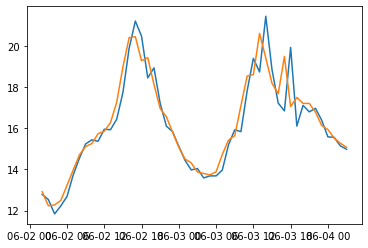

In [4]:
"""### LSTM Results"""

# flatten the results in 2D arrays into 1D array and store them into a pandas dataframe
test_results1 = pd.DataFrame(data={'Predicted Temp':y_test_pred1_destd.flatten(), 'Actual Temp':y_test_destd.flatten()}) 
test_results1.index = pd.to_datetime(hourly['Date Time'].iloc[65000+window_size:], format='%d.%m.%Y %H:%M:%S')
test_results1.head(10)

# visualize the forecast
import matplotlib.pyplot as plt
plt.plot(test_results1['Predicted Temp'].iloc[50:100])
plt.plot(test_results1['Actual Temp'].iloc[50:100])

# calculate the mse for test results
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(y_test_destd, y_test_pred1_destd)
mse1

0.6939201170327365

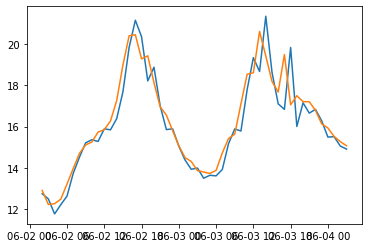

In [5]:
"""### Simple (vanilla) RNN results"""

# flatten the results in 2D arrays into 1D array and store them into a pandas dataframe
test_results2 = pd.DataFrame(data={'Predicted Temp':y_test_pred2_destd.flatten(), 'Actual Temp':y_test_destd.flatten()}) 
test_results2.index = pd.to_datetime(hourly['Date Time'].iloc[65000+window_size:], format='%d.%m.%Y %H:%M:%S')
test_results2.head(10)

# visualize the forecast
import matplotlib.pyplot as plt
plt.plot(test_results2['Predicted Temp'].iloc[50:100])
plt.plot(test_results2['Actual Temp'].iloc[50:100])

# calculate the mse for test results
from sklearn.metrics import mean_squared_error
mse2 = mean_squared_error(y_test_destd, y_test_pred2_destd)
mse2